In [1]:
import os
import glob
import time
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda")

In [2]:
def preplot(image):
    image = np.transpose(image, (1,2,0))
    image_color = np.zeros_like(image); 
    image_color[:,:,0] = image[:,:,2]; image_color[:,:,1]  = image[:,:,1]
    image_color[:,:,2] = image[:,:,0];
    out_image = np.flipud(np.clip(image_color, 0,1))
    return out_image[60:,62:-38,:]

In [3]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

def build_res_unet(n_input=3, n_output=3, size=256):
    device = torch.device("cuda")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [4]:
loadnet = build_res_unet(n_input=3, n_output=3, size=256)
loadnet.load_state_dict(
    torch.load('/home/vision/Desktop/Important/Lensless/Lensless-res18-Gen_50ep_L1andSSIM.pt'))

/home/vision/anaconda3/envs/torchgpu/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<All keys matched successfully>

In [13]:
path1 = '/media/vision/Data1/Datasets/Lensless/dataset/diffuser_images'
path2 = '/media/vision/Data1/Datasets/Lensless/dataset/ground_truth_lensed'
inpath = glob.glob(path1 + "/*.npy")
gtpath = glob.glob(path2 + "/*.npy")

testin = inpath[2000:]
testgt = gtpath[2000:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


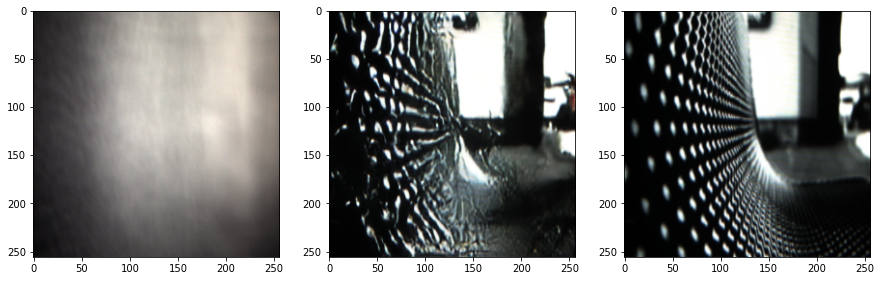

In [61]:
i=152

inp = np.load(testin[i]).transpose((2, 0, 1))
inp = preplot(inp)/np.max(inp)
inp = cv2.resize(inp, dsize=(256,256))
inp = torch.tensor(inp).permute(2,0,1).unsqueeze(0)
inp = inp.to(device)

gtr = np.load(testgt[i]).transpose((2, 0, 1))
gtr = preplot(gtr)/np.max(gtr)
gtr = cv2.resize(gtr, dsize=(256,256))
gtr = torch.tensor(gtr).permute(2,0,1).unsqueeze(0)
gtr = gtr.to(device)

pred = loadnet(inp)

f, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(inp[0].permute(1,2,0).cpu())
ax[1].imshow(pred[0].permute(1,2,0).cpu().detach().numpy())
ax[2].imshow(gtr[0].permute(1,2,0).cpu())

In [47]:
lenles = np.array(inp[0].permute(1,2,0).cpu())
recon = np.array(pred[0].permute(1,2,0).cpu().detach().numpy()).round(6)
truth = np.array(gtr[0].permute(1,2,0).cpu())

In [48]:
cv2.imwrite(f'/home/vision/Desktop/Important/Lensless/results/i141_in.jpg', 
            cv2.cvtColor((lenles*255).astype('uint8'), 
                         cv2.COLOR_RGB2BGR))
cv2.imwrite(f'/home/vision/Desktop/Important/Lensless/results/i141_ou.jpg', 
            cv2.cvtColor((recon*255), 
                         cv2.COLOR_RGB2BGR))
cv2.imwrite(f'/home/vision/Desktop/Important/Lensless/results/i141_gt.jpg', 
            cv2.cvtColor((truth*255).astype('uint8'), 
                         cv2.COLOR_RGB2BGR))

True

In [ ]:
img = plt.imread('/home/vision/Desktop/Important/Lensless/results/i4_in.jpg')
gtr1 = plt.imread('/home/vision/Desktop/Important/Lensless/results/i4_gt.jpg')

In [ ]:
size = (256,256)
proba_0 = 0.0               
# for speckle noise
noisy = np.random.choice([0,1], size=size, p=[proba_0, 1-proba_0])

def gkern(l=256, sig=150.):
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

g = gkern()
g = g/g.max()

noise = np.zeros([256,256,3])
noise[:,:,0] = noisy
noise[:,:,1] = noisy
noise[:,:,2] = noisy

corrupt = np.multiply(img, noise)
cor = cv2.medianBlur(corrupt.astype('uint8'),3)

In [ ]:
res = cv2.resize(img, dsize=(32,32))
res1 = cv2.resize(res, dsize=(256,256))

inp1 = torch.tensor(corrupt*1/255, dtype = torch.float).permute(2,0,1).unsqueeze(0)
inp1 = inp1.to(device)
pred1 = loadnet(inp1)

In [ ]:
f, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(corrupt*1/255)
ax[1].imshow(pred1[0].permute(1,2,0).cpu().detach().numpy())
ax[2].imshow(gtr1)

In [ ]:
c = np.where(img < 230, 0, img)
plt.imshow(c)